In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torch.nn as nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models

import torchvision.transforms as transforms

In [3]:
from functions import(import_train_folder_dataset,
                      Data,
                      import_test_folder_dataset,
                      Data_test,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      save_predictions_as_csv
                     )

# Variables

In [4]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 50 epochs

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass\\"

# Path of the Data files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Croped/Test"

cuda


# Import Data

In [5]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((400, 400)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

## Train-Val data

In [6]:
# Import the data
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Train Dim of Data: ", train_data.shape)
print("Train Dim of Lables: ", train_labels.shape)

Train Dim of Data:  (1149, 400, 400, 3)
Train Dim of Lables:  (1149,)


In [7]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 400, 400, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 400, 400, 3)
Dim of y_test:  (115,)


In [8]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [9]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

## Test Data

In [10]:
# Import the data
test_data, test_names = import_test_folder_dataset(test_data_path)
print("Test Dim of Data: ", test_data.shape)
print("Test Dim of Lables: ", test_names.shape)

Test Dim of Data:  (380, 400, 400, 3)
Test Dim of Lables:  (380,)


In [11]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_names, img_transform_val) # img_transform_2 img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [12]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

# Create Model

In [13]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, googlenet):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.googlenet_fe = nn.Sequential(*list(googlenet.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        #self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.googlenet_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(googlenet = models.googlenet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

In [14]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading saved checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


# Train Model

In [15]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Epoch 1 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.14540997758594196
Val loss:  0.13953136102012967
train accuracy:  0.4448742746615087
Val accuracy:  0.5652173913043478
Best model at the moment with Val_acc 56.52, saving...
Current time: 0.958 minutes. Time expected till completion: 94.800 minutes
Epoch 2 of 100


100%|██████████| 15/15 [00:02<00:00,  7.10it/s]


train loss:  0.13292423011717067
Val loss:  0.13344573870949122
train accuracy:  0.539651837524178
Val accuracy:  0.5130434782608696
Current time: 1.845 minutes. Time expected till completion: 90.384 minutes
Epoch 3 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.12976396792861894
Val loss:  0.12967784197434135
train accuracy:  0.5502901353965184
Val accuracy:  0.5304347826086957
Current time: 2.730 minutes. Time expected till completion: 88.268 minutes
Epoch 4 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.12480825779516416
Val loss:  0.12563413848047672
train accuracy:  0.6015473887814313
Val accuracy:  0.5565217391304348
Current time: 3.618 minutes. Time expected till completion: 86.838 minutes
Epoch 5 of 100


100%|██████████| 15/15 [00:02<00:00,  6.97it/s]


train loss:  0.12089302386490473
Val loss:  0.12256373426188594
train accuracy:  0.5986460348162476
Val accuracy:  0.5130434782608696
Current time: 4.506 minutes. Time expected till completion: 85.608 minutes
Epoch 6 of 100


100%|██████████| 15/15 [00:02<00:00,  7.17it/s]


train loss:  0.11991291650259288
Val loss:  0.11995944665825885
train accuracy:  0.6005802707930368
Val accuracy:  0.5478260869565217
Current time: 5.389 minutes. Time expected till completion: 84.421 minutes
Epoch 7 of 100


100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


train loss:  0.11657388730252043
Val loss:  0.11837021941724031
train accuracy:  0.6083172147001934
Val accuracy:  0.5304347826086957
Current time: 6.273 minutes. Time expected till completion: 83.343 minutes
Epoch 8 of 100


100%|██████████| 15/15 [00:02<00:00,  7.21it/s]


train loss:  0.11310583223341973
Val loss:  0.11697438022364741
train accuracy:  0.6131528046421664
Val accuracy:  0.5304347826086957
Current time: 7.155 minutes. Time expected till completion: 82.288 minutes
Epoch 9 of 100


100%|██████████| 15/15 [00:02<00:00,  7.13it/s]


train loss:  0.11251191293363184
Val loss:  0.11543897079384845
train accuracy:  0.6199226305609284
Val accuracy:  0.5304347826086957
Current time: 8.039 minutes. Time expected till completion: 81.279 minutes
Epoch 10 of 100


100%|██████████| 15/15 [00:02<00:00,  7.07it/s]


train loss:  0.11101285346587346
Val loss:  0.11516826152801514
train accuracy:  0.6218568665377177
Val accuracy:  0.5391304347826087
Current time: 8.921 minutes. Time expected till completion: 80.290 minutes
Epoch 11 of 100


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


train loss:  0.1099919442454897
Val loss:  0.11397584624912428
train accuracy:  0.6160541586073501
Val accuracy:  0.5478260869565217
Current time: 9.804 minutes. Time expected till completion: 79.327 minutes
Epoch 12 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.11044603419027199
Val loss:  0.11143321265345034
train accuracy:  0.6189555125725339
Val accuracy:  0.6086956521739131
Best model at the moment with Val_acc 60.87, saving...
Current time: 10.689 minutes. Time expected till completion: 78.383 minutes
Epoch 13 of 100


100%|██████████| 15/15 [00:02<00:00,  7.08it/s]


train loss:  0.10971144709296568
Val loss:  0.11184939768003381
train accuracy:  0.6121856866537717
Val accuracy:  0.5739130434782609
Current time: 11.573 minutes. Time expected till completion: 77.449 minutes
Epoch 14 of 100


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


train loss:  0.10992857199918832
Val loss:  0.11211600666460783
train accuracy:  0.6247582205029013
Val accuracy:  0.5652173913043478
Current time: 12.453 minutes. Time expected till completion: 76.496 minutes
Epoch 15 of 100


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


train loss:  0.10960352709030506
Val loss:  0.1111451752807783
train accuracy:  0.6315280464216635
Val accuracy:  0.5826086956521739
Current time: 13.336 minutes. Time expected till completion: 75.572 minutes
Epoch 16 of 100


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


train loss:  0.10740971622891306
Val loss:  0.10855922025182972
train accuracy:  0.6266924564796905
Val accuracy:  0.6
Current time: 14.222 minutes. Time expected till completion: 74.664 minutes
Epoch 17 of 100


100%|██████████| 15/15 [00:02<00:00,  6.77it/s]


train loss:  0.10605021164080622
Val loss:  0.10848931385123212
train accuracy:  0.6537717601547389
Val accuracy:  0.6086956521739131
Current time: 15.106 minutes. Time expected till completion: 73.755 minutes
Epoch 18 of 100


100%|██████████| 15/15 [00:02<00:00,  7.13it/s]


train loss:  0.10683596975798763
Val loss:  0.1079604560914247
train accuracy:  0.6228239845261122
Val accuracy:  0.6173913043478261
Best model at the moment with Val_acc 61.74, saving...
Current time: 15.994 minutes. Time expected till completion: 72.862 minutes
Epoch 19 of 100


100%|██████████| 15/15 [00:02<00:00,  7.08it/s]


train loss:  0.1049501579723229
Val loss:  0.1095566433408986
train accuracy:  0.632495164410058
Val accuracy:  0.591304347826087
Current time: 16.878 minutes. Time expected till completion: 71.952 minutes
Epoch 20 of 100


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


train loss:  0.10504192955489315
Val loss:  0.10730809387953386
train accuracy:  0.6382978723404256
Val accuracy:  0.6347826086956522
Best model at the moment with Val_acc 63.48, saving...
Current time: 17.767 minutes. Time expected till completion: 71.070 minutes
Epoch 21 of 100


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


train loss:  0.10325658491432552
Val loss:  0.10471817229105079
train accuracy:  0.6295938104448743
Val accuracy:  0.591304347826087
Current time: 18.663 minutes. Time expected till completion: 70.210 minutes
Epoch 22 of 100


100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


train loss:  0.10458188214315897
Val loss:  0.1027289823345516
train accuracy:  0.6344294003868471
Val accuracy:  0.6260869565217392
Current time: 19.549 minutes. Time expected till completion: 69.309 minutes
Epoch 23 of 100


100%|██████████| 15/15 [00:02<00:00,  6.69it/s]


train loss:  0.10439180468913434
Val loss:  0.10666852878487629
train accuracy:  0.6334622823984526
Val accuracy:  0.6260869565217392
Current time: 20.438 minutes. Time expected till completion: 68.422 minutes
Epoch 24 of 100


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


train loss:  0.10139788499883803
Val loss:  0.10336617931075719
train accuracy:  0.6479690522243714
Val accuracy:  0.6260869565217392
Current time: 21.329 minutes. Time expected till completion: 67.540 minutes
Epoch 25 of 100


100%|██████████| 15/15 [00:02<00:00,  5.00it/s]


train loss:  0.10329887775318766
Val loss:  0.10358831752901491
train accuracy:  0.6353965183752418
Val accuracy:  0.6173913043478261
Current time: 22.274 minutes. Time expected till completion: 66.823 minutes
Epoch 26 of 100


100%|██████████| 15/15 [00:02<00:00,  6.72it/s]


train loss:  0.10138619730043688
Val loss:  0.10218291749124941
train accuracy:  0.6411992263056093
Val accuracy:  0.6347826086956522
Current time: 23.199 minutes. Time expected till completion: 66.028 minutes
Epoch 27 of 100


100%|██████████| 15/15 [00:02<00:00,  6.64it/s]


train loss:  0.10153492685674007
Val loss:  0.10731430623842322
train accuracy:  0.6566731141199227
Val accuracy:  0.6260869565217392
Current time: 24.116 minutes. Time expected till completion: 65.202 minutes
Epoch 28 of 100


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


train loss:  0.10306722747172793
Val loss:  0.10246333635371664
train accuracy:  0.6421663442940039
Val accuracy:  0.6347826086956522
Current time: 25.041 minutes. Time expected till completion: 64.390 minutes
Epoch 29 of 100


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.10340886282044638
Val loss:  0.10320575107698855
train accuracy:  0.6353965183752418
Val accuracy:  0.6260869565217392
Current time: 25.958 minutes. Time expected till completion: 63.553 minutes
Epoch 30 of 100


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.1021339937727502
Val loss:  0.10311296167580977
train accuracy:  0.6353965183752418
Val accuracy:  0.6173913043478261
Current time: 26.901 minutes. Time expected till completion: 62.769 minutes
Epoch 31 of 100


100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


train loss:  0.09911201225604495
Val loss:  0.10157192401264024
train accuracy:  0.6615087040618955
Val accuracy:  0.6347826086956522
Current time: 27.890 minutes. Time expected till completion: 62.078 minutes
Epoch 32 of 100


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]


train loss:  0.09956456233731091
Val loss:  0.10309467859890149
train accuracy:  0.6798839458413927
Val accuracy:  0.6173913043478261
Current time: 28.882 minutes. Time expected till completion: 61.374 minutes
Epoch 33 of 100


100%|██████████| 15/15 [00:02<00:00,  6.61it/s]


train loss:  0.09669390130550304
Val loss:  0.10451436172360959
train accuracy:  0.6711798839458414
Val accuracy:  0.6173913043478261
Current time: 29.793 minutes. Time expected till completion: 60.488 minutes
Epoch 34 of 100


100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


train loss:  0.09875779312168836
Val loss:  0.10593408216600833
train accuracy:  0.6740812379110251
Val accuracy:  0.6434782608695652
Best model at the moment with Val_acc 64.35, saving...
Current time: 30.699 minutes. Time expected till completion: 59.592 minutes
Epoch 35 of 100


100%|██████████| 15/15 [00:02<00:00,  6.32it/s]


train loss:  0.09868274568589099
Val loss:  0.10496075257011082
train accuracy:  0.6508704061895552
Val accuracy:  0.6521739130434783
Best model at the moment with Val_acc 65.22, saving...
Current time: 31.634 minutes. Time expected till completion: 58.750 minutes
Epoch 36 of 100


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


train loss:  0.09570750150274723
Val loss:  0.0987476646900177
train accuracy:  0.6721470019342359
Val accuracy:  0.6434782608695652
Current time: 32.571 minutes. Time expected till completion: 57.904 minutes
Epoch 37 of 100


100%|██████████| 15/15 [00:02<00:00,  6.20it/s]


train loss:  0.0969454219539576
Val loss:  0.10335905240929645
train accuracy:  0.6769825918762089
Val accuracy:  0.6
Current time: 33.504 minutes. Time expected till completion: 57.048 minutes
Epoch 38 of 100


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


train loss:  0.09729826349469634
Val loss:  0.10083521500877712
train accuracy:  0.6537717601547389
Val accuracy:  0.6695652173913044
Best model at the moment with Val_acc 66.96, saving...
Current time: 34.492 minutes. Time expected till completion: 56.277 minutes
Epoch 39 of 100


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.09606480895320037
Val loss:  0.10494392980699954
train accuracy:  0.6682785299806576
Val accuracy:  0.5826086956521739
Current time: 35.431 minutes. Time expected till completion: 55.418 minutes
Epoch 40 of 100


100%|██████████| 15/15 [00:02<00:00,  6.75it/s]


train loss:  0.09450584070710195
Val loss:  0.10527813745581585
train accuracy:  0.6731141199226306
Val accuracy:  0.6
Current time: 36.364 minutes. Time expected till completion: 54.546 minutes
Epoch 41 of 100


100%|██████████| 15/15 [00:02<00:00,  5.78it/s]


train loss:  0.09577028202595517
Val loss:  0.10403945394184279
train accuracy:  0.6595744680851063
Val accuracy:  0.591304347826087
Current time: 37.303 minutes. Time expected till completion: 53.680 minutes
Epoch 42 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.09479593195929056
Val loss:  0.10519692845966505
train accuracy:  0.6798839458413927
Val accuracy:  0.6347826086956522
Current time: 38.223 minutes. Time expected till completion: 52.785 minutes
Epoch 43 of 100


100%|██████████| 15/15 [00:02<00:00,  6.26it/s]


train loss:  0.09353278784848736
Val loss:  0.10336385628451472
train accuracy:  0.695357833655706
Val accuracy:  0.6347826086956522
Current time: 39.171 minutes. Time expected till completion: 51.924 minutes
Epoch 44 of 100


100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


train loss:  0.0921026371433841
Val loss:  0.10430283131806747
train accuracy:  0.6769825918762089
Val accuracy:  0.6260869565217392
Current time: 40.100 minutes. Time expected till completion: 51.037 minutes
Epoch 45 of 100


100%|██████████| 15/15 [00:02<00:00,  5.92it/s]


train loss:  0.09223953627294913
Val loss:  0.1040265775245169
train accuracy:  0.6972920696324951
Val accuracy:  0.6347826086956522
Current time: 41.043 minutes. Time expected till completion: 50.164 minutes
Epoch 46 of 100


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.09516064681444224
Val loss:  0.10546200767807339
train accuracy:  0.6682785299806576
Val accuracy:  0.6086956521739131
Current time: 41.974 minutes. Time expected till completion: 49.273 minutes
Epoch 47 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.09611341311115361
Val loss:  0.10146184874617535
train accuracy:  0.6827852998065764
Val accuracy:  0.6086956521739131
Current time: 42.896 minutes. Time expected till completion: 48.373 minutes
Epoch 48 of 100


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


train loss:  0.09267489424757155
Val loss:  0.10352558208548504
train accuracy:  0.6847195357833655
Val accuracy:  0.6173913043478261
Current time: 43.809 minutes. Time expected till completion: 47.460 minutes
Epoch 49 of 100


100%|██████████| 15/15 [00:02<00:00,  6.85it/s]


train loss:  0.08941236028818836
Val loss:  0.10621517404266026
train accuracy:  0.7030947775628626
Val accuracy:  0.6260869565217392
Current time: 44.746 minutes. Time expected till completion: 46.573 minutes
Epoch 50 of 100


100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


train loss:  0.08887794593662543
Val loss:  0.10530579090118408
train accuracy:  0.7040618955512572
Val accuracy:  0.6434782608695652
Current time: 45.649 minutes. Time expected till completion: 45.649 minutes
Epoch 51 of 100


100%|██████████| 15/15 [00:02<00:00,  5.77it/s]


train loss:  0.09272443271121389
Val loss:  0.1026514320269875
train accuracy:  0.6856866537717602
Val accuracy:  0.6434782608695652
Current time: 46.563 minutes. Time expected till completion: 44.737 minutes
Epoch 52 of 100


100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


train loss:  0.09027085964868793
Val loss:  0.10294642500255419
train accuracy:  0.695357833655706
Val accuracy:  0.591304347826087
Current time: 47.499 minutes. Time expected till completion: 43.846 minutes
Epoch 53 of 100


100%|██████████| 15/15 [00:02<00:00,  6.13it/s]


train loss:  0.09069108219395754
Val loss:  0.10090598049371138
train accuracy:  0.6934235976789168
Val accuracy:  0.6695652173913044
Current time: 48.427 minutes. Time expected till completion: 42.945 minutes
Epoch 54 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.08955800002963216
Val loss:  0.10556601337764575
train accuracy:  0.7050290135396519
Val accuracy:  0.6260869565217392
Current time: 49.353 minutes. Time expected till completion: 42.041 minutes
Epoch 55 of 100


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.08736771013681385
Val loss:  0.1070502142543378
train accuracy:  0.7224371373307543
Val accuracy:  0.6434782608695652
Current time: 50.266 minutes. Time expected till completion: 41.127 minutes
Epoch 56 of 100


100%|██████████| 15/15 [00:02<00:00,  6.61it/s]


train loss:  0.08538188210308437
Val loss:  0.10653685720070549
train accuracy:  0.7059961315280464
Val accuracy:  0.6260869565217392
Current time: 51.176 minutes. Time expected till completion: 40.210 minutes
Epoch 57 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.08823441853836841
Val loss:  0.1066467971905418
train accuracy:  0.706963249516441
Val accuracy:  0.6260869565217392
Current time: 52.081 minutes. Time expected till completion: 39.289 minutes
Epoch 58 of 100


100%|██████████| 15/15 [00:02<00:00,  6.70it/s]


train loss:  0.08789605367748604
Val loss:  0.10517564623252205
train accuracy:  0.695357833655706
Val accuracy:  0.6086956521739131
Current time: 52.987 minutes. Time expected till completion: 38.370 minutes
Epoch 59 of 100


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.08802237083533747
Val loss:  0.10811447617800339
train accuracy:  0.7059961315280464
Val accuracy:  0.6434782608695652
Current time: 53.894 minutes. Time expected till completion: 37.452 minutes
Epoch 60 of 100


100%|██████████| 15/15 [00:02<00:00,  6.63it/s]


train loss:  0.08854742221375729
Val loss:  0.1046524641306504
train accuracy:  0.7030947775628626
Val accuracy:  0.6608695652173913
Current time: 54.795 minutes. Time expected till completion: 36.530 minutes
Epoch 61 of 100


100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


train loss:  0.0870445755452667
Val loss:  0.10460370662419692
train accuracy:  0.706963249516441
Val accuracy:  0.6173913043478261
Current time: 55.695 minutes. Time expected till completion: 35.608 minutes
Epoch 62 of 100


100%|██████████| 15/15 [00:02<00:00,  6.96it/s]


train loss:  0.08440795483164908
Val loss:  0.10603847140851227
train accuracy:  0.7253384912959381
Val accuracy:  0.5826086956521739
Current time: 56.593 minutes. Time expected till completion: 34.686 minutes
Epoch 63 of 100


100%|██████████| 15/15 [00:02<00:00,  6.60it/s]


train loss:  0.08632031942013385
Val loss:  0.10120275020599365
train accuracy:  0.7059961315280464
Val accuracy:  0.6521739130434783
Current time: 57.495 minutes. Time expected till completion: 33.767 minutes
Epoch 64 of 100


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.08657095674965783
Val loss:  0.10547287697377412
train accuracy:  0.7137330754352031
Val accuracy:  0.6260869565217392
Current time: 58.394 minutes. Time expected till completion: 32.847 minutes
Epoch 65 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.08268970202085359
Val loss:  0.1075799822807312
train accuracy:  0.7127659574468085
Val accuracy:  0.6347826086956522
Current time: 59.293 minutes. Time expected till completion: 31.927 minutes
Epoch 66 of 100


100%|██████████| 15/15 [00:02<00:00,  6.71it/s]


train loss:  0.08257114279085709
Val loss:  0.10718180096667745
train accuracy:  0.7205029013539652
Val accuracy:  0.6434782608695652
Current time: 60.193 minutes. Time expected till completion: 31.008 minutes
Epoch 67 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.08390143670761378
Val loss:  0.109217318503753
train accuracy:  0.7253384912959381
Val accuracy:  0.6086956521739131
Current time: 61.092 minutes. Time expected till completion: 30.090 minutes
Epoch 68 of 100


100%|██████████| 15/15 [00:02<00:00,  6.73it/s]


train loss:  0.08119799666524626
Val loss:  0.1060462272685507
train accuracy:  0.7224371373307543
Val accuracy:  0.6608695652173913
Current time: 61.991 minutes. Time expected till completion: 29.172 minutes
Epoch 69 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.08214340583786973
Val loss:  0.10503101193386576
train accuracy:  0.7166344294003868
Val accuracy:  0.6260869565217392
Current time: 62.891 minutes. Time expected till completion: 28.255 minutes
Epoch 70 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.08138032416079907
Val loss:  0.10922298172245855
train accuracy:  0.7475822050290135
Val accuracy:  0.6260869565217392
Current time: 63.786 minutes. Time expected till completion: 27.337 minutes
Epoch 71 of 100


100%|██████████| 15/15 [00:02<00:00,  6.63it/s]


train loss:  0.08055465682851046
Val loss:  0.10824282013851663
train accuracy:  0.7311411992263056
Val accuracy:  0.6173913043478261
Current time: 64.688 minutes. Time expected till completion: 26.422 minutes
Epoch 72 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.08089997349901402
Val loss:  0.11075060004773347
train accuracy:  0.723404255319149
Val accuracy:  0.6347826086956522
Current time: 65.585 minutes. Time expected till completion: 25.505 minutes
Epoch 73 of 100


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


train loss:  0.0780188936300619
Val loss:  0.11001083760157876
train accuracy:  0.7601547388781431
Val accuracy:  0.6347826086956522
Current time: 66.486 minutes. Time expected till completion: 24.591 minutes
Epoch 74 of 100


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.08011589063839479
Val loss:  0.11680677377659342
train accuracy:  0.7388781431334622
Val accuracy:  0.6
Current time: 67.386 minutes. Time expected till completion: 23.676 minutes
Epoch 75 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.07519222425595935
Val loss:  0.11130661808926126
train accuracy:  0.7562862669245648
Val accuracy:  0.6
Current time: 68.287 minutes. Time expected till completion: 22.762 minutes
Epoch 76 of 100


100%|██████████| 15/15 [00:02<00:00,  6.66it/s]


train loss:  0.07817022084498082
Val loss:  0.1129753422477971
train accuracy:  0.7514506769825918
Val accuracy:  0.6
Current time: 69.186 minutes. Time expected till completion: 21.848 minutes
Epoch 77 of 100


100%|██████████| 15/15 [00:02<00:00,  6.94it/s]


train loss:  0.07482238982874374
Val loss:  0.11372490913971611
train accuracy:  0.7707930367504836
Val accuracy:  0.6173913043478261
Current time: 70.083 minutes. Time expected till completion: 20.934 minutes
Epoch 78 of 100


100%|██████████| 15/15 [00:02<00:00,  6.89it/s]


train loss:  0.07442271170463968
Val loss:  0.11185913008192311
train accuracy:  0.7591876208897486
Val accuracy:  0.6521739130434783
Current time: 70.985 minutes. Time expected till completion: 20.021 minutes
Epoch 79 of 100


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


train loss:  0.0775333182954696
Val loss:  0.10948380620583244
train accuracy:  0.7408123791102514
Val accuracy:  0.6260869565217392
Current time: 71.885 minutes. Time expected till completion: 19.109 minutes
Epoch 80 of 100


100%|██████████| 15/15 [00:02<00:00,  6.90it/s]


train loss:  0.07434510696153346
Val loss:  0.10937787242557691
train accuracy:  0.7640232108317214
Val accuracy:  0.6521739130434783
Current time: 72.783 minutes. Time expected till completion: 18.196 minutes
Epoch 81 of 100


100%|██████████| 15/15 [00:02<00:00,  6.83it/s]


train loss:  0.07512794188593065
Val loss:  0.11576489184213722
train accuracy:  0.7514506769825918
Val accuracy:  0.6086956521739131
Current time: 73.679 minutes. Time expected till completion: 17.283 minutes
Epoch 82 of 100


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.07781585840584
Val loss:  0.11063843110333318
train accuracy:  0.7504835589941973
Val accuracy:  0.6608695652173913
Current time: 74.579 minutes. Time expected till completion: 16.371 minutes
Epoch 83 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.0719235917441619
Val loss:  0.11049951522246651
train accuracy:  0.7736943907156673
Val accuracy:  0.6434782608695652
Current time: 75.476 minutes. Time expected till completion: 15.459 minutes
Epoch 84 of 100


100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


train loss:  0.07415615497751439
Val loss:  0.11371466310127921
train accuracy:  0.7591876208897486
Val accuracy:  0.6434782608695652
Current time: 76.378 minutes. Time expected till completion: 14.548 minutes
Epoch 85 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.0733961368148977
Val loss:  0.1094562001850294
train accuracy:  0.7649903288201161
Val accuracy:  0.6521739130434783
Current time: 77.278 minutes. Time expected till completion: 13.637 minutes
Epoch 86 of 100


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


train loss:  0.07085759092547446
Val loss:  0.12093455558237823
train accuracy:  0.7736943907156673
Val accuracy:  0.6
Current time: 78.173 minutes. Time expected till completion: 12.726 minutes
Epoch 87 of 100


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.07258569522683349
Val loss:  0.11281407993772756
train accuracy:  0.7746615087040619
Val accuracy:  0.6260869565217392
Current time: 79.073 minutes. Time expected till completion: 11.816 minutes
Epoch 88 of 100


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


train loss:  0.07328271658323719
Val loss:  0.11012726801892986
train accuracy:  0.7620889748549323
Val accuracy:  0.6434782608695652
Current time: 79.972 minutes. Time expected till completion: 10.905 minutes
Epoch 89 of 100


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.07192245533606992
Val loss:  0.11312785342983578
train accuracy:  0.7843326885880078
Val accuracy:  0.6173913043478261
Current time: 80.878 minutes. Time expected till completion: 9.996 minutes
Epoch 90 of 100


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06957177778911314
Val loss:  0.112622265258561
train accuracy:  0.7978723404255319
Val accuracy:  0.6173913043478261
Current time: 81.781 minutes. Time expected till completion: 9.087 minutes
Epoch 91 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.06822598270164007
Val loss:  0.11494373258041299
train accuracy:  0.7920696324951644
Val accuracy:  0.6173913043478261
Current time: 82.680 minutes. Time expected till completion: 8.177 minutes
Epoch 92 of 100


100%|██████████| 15/15 [00:02<00:00,  6.79it/s]


train loss:  0.06624520684608638
Val loss:  0.11870334828677384
train accuracy:  0.7872340425531915
Val accuracy:  0.6347826086956522
Current time: 83.579 minutes. Time expected till completion: 7.268 minutes
Epoch 93 of 100


100%|██████████| 15/15 [00:02<00:00,  6.84it/s]


train loss:  0.0659433930997
Val loss:  0.11572973371847817
train accuracy:  0.7998065764023211
Val accuracy:  0.6347826086956522
Current time: 84.479 minutes. Time expected till completion: 6.359 minutes
Epoch 94 of 100


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


train loss:  0.06292085634901169
Val loss:  0.11763124815795732
train accuracy:  0.8143133462282398
Val accuracy:  0.6434782608695652
Current time: 85.377 minutes. Time expected till completion: 5.450 minutes
Epoch 95 of 100


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06754227687300289
Val loss:  0.12014599494312121
train accuracy:  0.7911025145067698
Val accuracy:  0.6521739130434783
Current time: 86.281 minutes. Time expected till completion: 4.541 minutes
Epoch 96 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.06652859654601814
Val loss:  0.12520110879255378
train accuracy:  0.7862669245647969
Val accuracy:  0.6260869565217392
Current time: 87.181 minutes. Time expected till completion: 3.633 minutes
Epoch 97 of 100


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]


train loss:  0.06709496470841955
Val loss:  0.13355516661768374
train accuracy:  0.781431334622824
Val accuracy:  0.6521739130434783
Current time: 88.079 minutes. Time expected till completion: 2.724 minutes
Epoch 98 of 100


100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


train loss:  0.06278851435193702
Val loss:  0.11723342615625133
train accuracy:  0.804642166344294
Val accuracy:  0.6347826086956522
Current time: 88.980 minutes. Time expected till completion: 1.816 minutes
Epoch 99 of 100


100%|██████████| 15/15 [00:02<00:00,  6.81it/s]


train loss:  0.06591070173902715
Val loss:  0.11475133332221404
train accuracy:  0.7988394584139265
Val accuracy:  0.6695652173913044
Current time: 89.879 minutes. Time expected till completion: 0.908 minutes
Epoch 100 of 100


100%|██████████| 15/15 [00:02<00:00,  6.78it/s]


train loss:  0.06395600530061316
Val loss:  0.12442220358744911
train accuracy:  0.7959381044487428
Val accuracy:  0.6347826086956522
Saving model 2 checkpoint


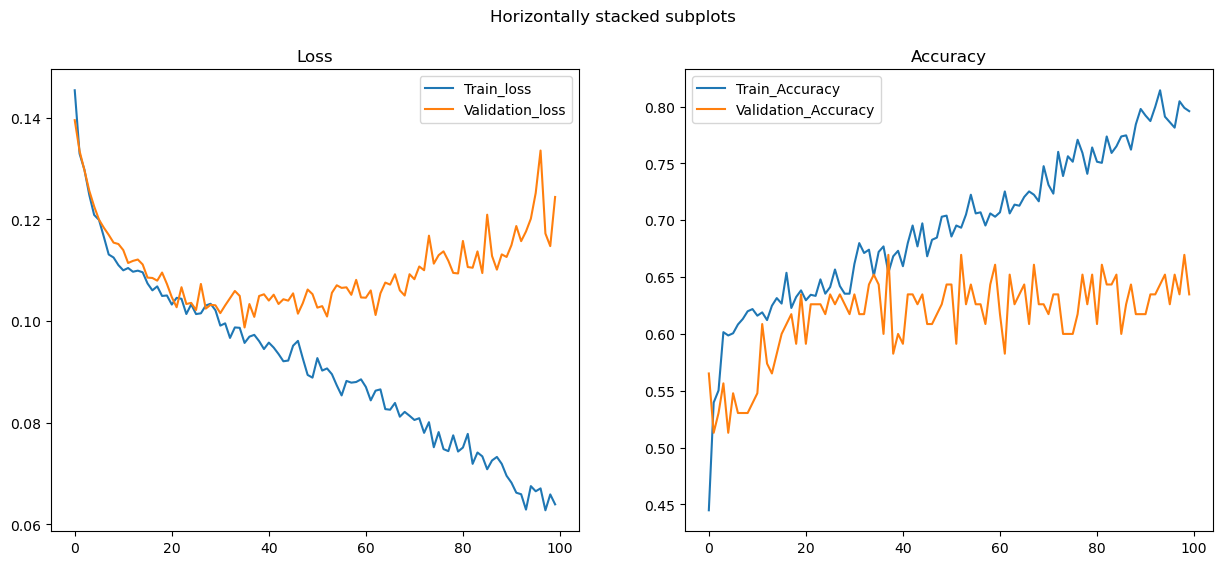

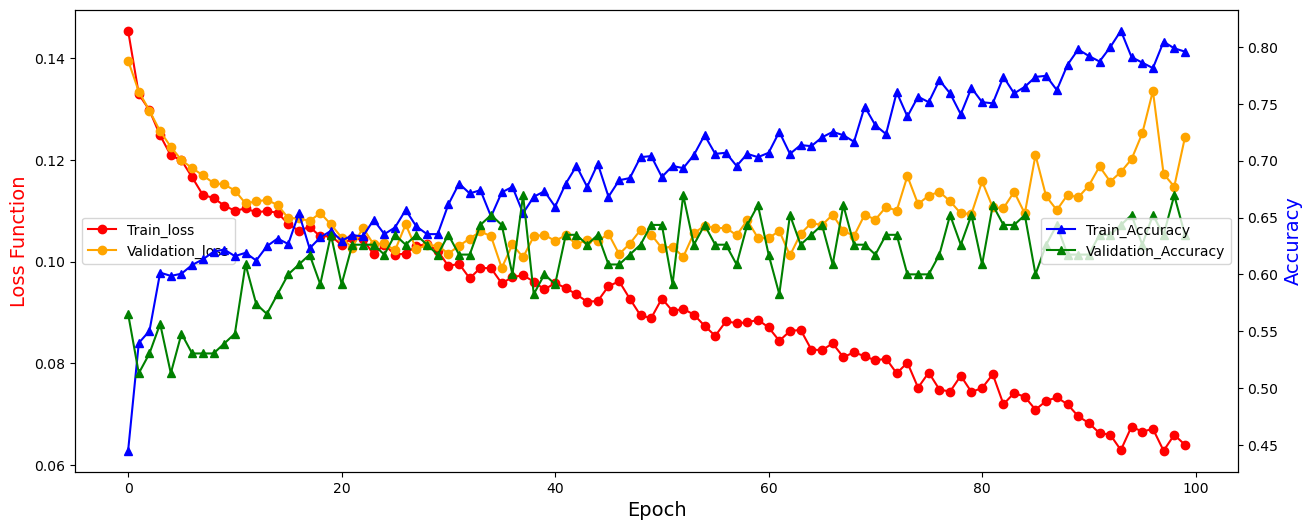

Current time: 90.861 minutes. Time expected till completion: 0.000 minutes
Finished training in: 90.861 minutes


In [16]:

best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()

# count time
start = time.time()
for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer_2, 0.001)
        
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)    
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name)
        best_model_val_acc = val_epoch_accuracy
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Check the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [17]:
best_model_val_acc

0.6695652173913044

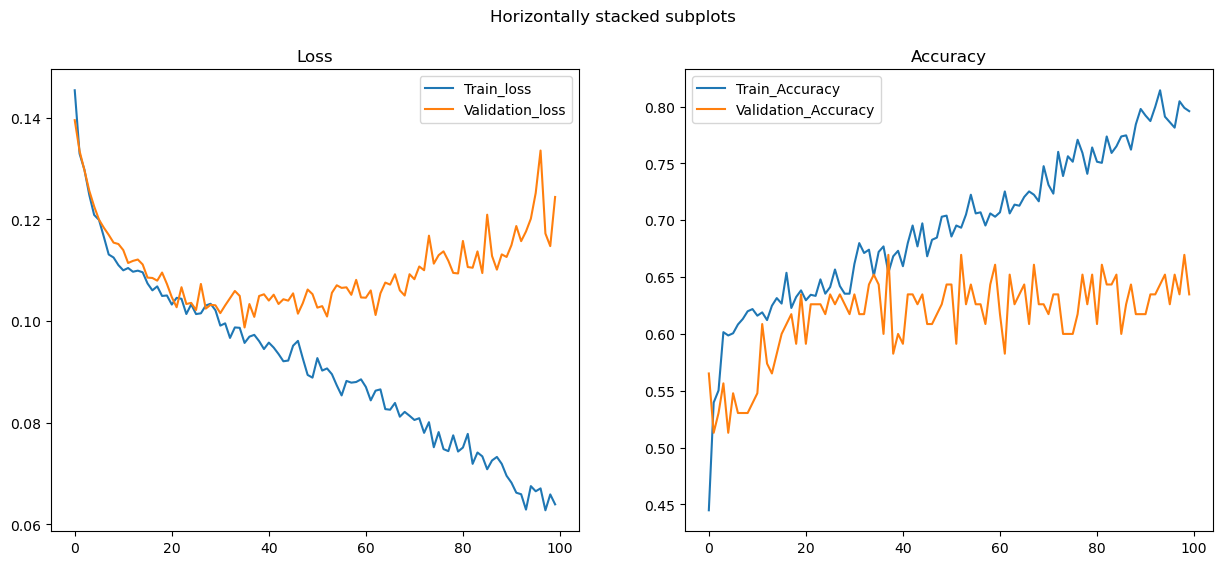

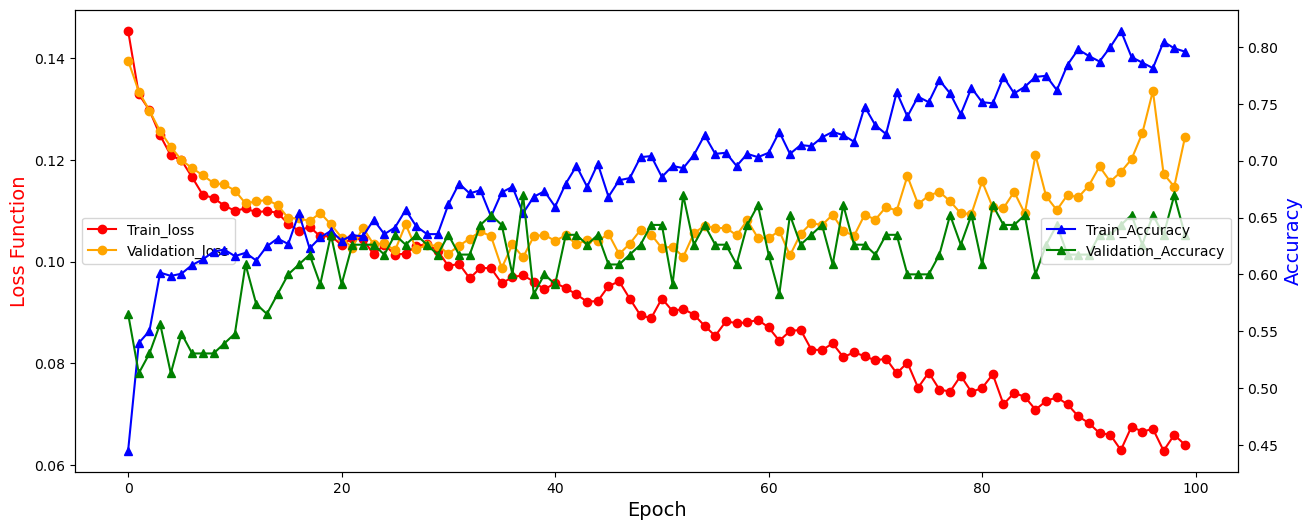

In [18]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

## Save model

In [19]:
# Save Model
NAME2 = "model_2.pt"

torch.save(modelpy, PATH+NAME2)

# Load Last Model

In [20]:
# Load the model
NAME = "model_2.pt"
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Last Model

In [21]:
def accuracy_given_set(mm2, valid_loader, device, name="Validation"):
    # Evaluate the Validation Set
    mm2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            new_images = data[0].to(device)

            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

            total += data[1].size(0)
            correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [22]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:20<00:00,  6.41it/s]


Accuracy of the network on the 1034 Train instances: 87.04061895551257%


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]

Accuracy of the network on the 115 Validation instances: 63.47826086956522%


## Test Predictions Last Model

In [23]:
def make_predictions(mm2, loader, device):
    # Evaluate the Validation Set
    mm2.eval()
    predictions_list = []
    name_list = []
    
    with torch.no_grad():
        for bi, data in tqdm(enumerate(loader), total=len(loader)):
            new_images = data[0].to(device)
        
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
            predictions_list.append(predictions[0].item())
            name_list.append(data[1][0])
        
    return(predictions_list, name_list)

In [24]:
pred, names = make_predictions(modelpy, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:12<00:00, 29.68it/s]


(array([0, 1, 2]), array([143, 184,  53], dtype=int64))

In [25]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_GoogLeNet_prediction.csv")

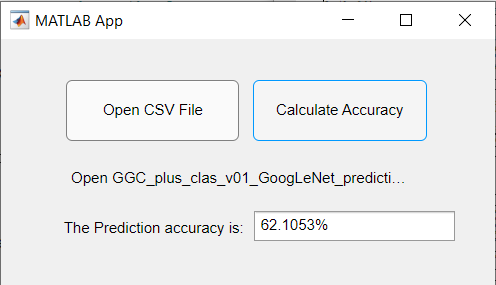

# Load Best Model

In [26]:
# Load the model
NAME = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Best Model

In [27]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy_bestModel, train_loader, device, name="Train")
accuracy_given_set(modelpy_bestModel, valid_loader, device, name="Validation")

100%|██████████| 130/130 [00:20<00:00,  6.39it/s]


Accuracy of the network on the 1034 Train instances: 71.08317214700193%


100%|██████████| 15/15 [00:02<00:00,  6.87it/s]

Accuracy of the network on the 115 Validation instances: 66.95652173913044%


## Test Predictions Best Model

In [28]:
pred, names = make_predictions(modelpy_bestModel, test_loader, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:10<00:00, 37.94it/s]


(array([0, 1, 2]), array([159, 174,  47], dtype=int64))

In [29]:
save_predictions_as_csv(names, pred, name="GGC_plus_clas_v01_GoogLeNet_best_prediction.csv")

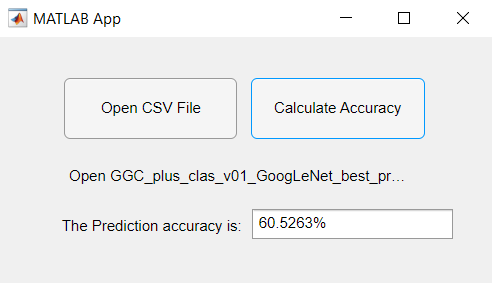